# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [3]:
import numpy as np
import pandas as pd
import scipy

"""
処理の戦略
Fsで指定したサンプリングレートで合成波を生成して、
その信号をkで指定する周波数のサンプリングレートに落としてFPAkの処理を実行する。
"""

Fs = 20000 # サンプリングレート
Nyquist_Fs = int(Fs/2) # ナイキスト周波数(グラフ表示用)
Time = 1.0 # 分析期間
F_1 = 2100 # 周波数1
F_2 = 1000 # 周波数2
F_c = 4000 # 固定しておく周波数
k = 10000 # 分析をする周波数

DATA_COUNTS = 10 # sin波の個数今回は10個生成
epsilon = 2 # ノイズの加算量を調整するパラメータ 2程度が一般的

# グラフ表示用
time_count = np.arange(0, Time, 1/Fs)
time_count_k = np.arange(0, Time, 1/k)

# 合成波の生成用関数
def sin_wave_gen(Freq_1, Freq_2, time_count):
    sin_waves = []
    for i in range(DATA_COUNTS):
        if i < DATA_COUNTS / 2:
            sin_waves.append(1.0 * np.sin(2.0 * np.pi*Freq_1*time_count) + 1.0 * np.sin(2.0 *np.pi*F_c*time_count))
        else:
            sin_waves.append(1.0 * np.sin(2.0 * np.pi*Freq_2*time_count) + 3.0 * np.sin(2.0 *np.pi*F_c*time_count))
    sin_waves = np.array(sin_waves)
    return sin_waves

# 合成波の生成
sin_wave = sin_wave_gen(Freq_1=F_1, Freq_2=F_2, time_count=time_count)

# ダウンサンプリング関数
# https://qiita.com/sumita_v09/items/808a3f8506065639cf51 を参考に作成
def downsampling(target_rate: int, data: np.array, fs: int) -> (np.array, int):

    # 間引くサンプル数を決める
    decimation_sampleNum = int((fs/target_rate)-1)

    # FIRフィルタの用意をする
    nyqF = (target_rate)/2.0            # 変換後のナイキスト周波数
    cF = (target_rate/2.0-500.)/nyqF    # カットオフ周波数を設定（変換前のナイキスト周波数より少し下を設定）
    taps = 511                          # フィルタ係数（奇数じゃないとだめ）
    b = scipy.signal.firwin(taps, cF)   # LPFを用意

    # フィルタリング
    data = scipy.signal.lfilter(b, 1, data)

    # 間引き処理
    down_data = []
    for i in range(0, len(data), decimation_sampleNum+1):
        down_data.append(data[i])

    return (down_data)

# 合成波をダウンサンプリング
sin_wave_ds = np.array([downsampling(target_rate=k, data=sin_wave[i,:], fs=Fs) for i in range(DATA_COUNTS)])

# ラプラスノイズの幅を指定するパラメータを算出
q_d = np.array([sin_wave_ds[:,i] - sin_wave_ds[:,i-1] for i in range(1,len(time_count_k))])
q_L2 = np.array([np.linalg.norm(q_d[:,i], ord=2) for i in range(DATA_COUNTS)])
lamda = np.array(np.sqrt(k/4*Time) * q_L2 / epsilon)

# ランダム生成器の宣言
rng = np.random.default_rng()

# ラプラスノイズ生成関数
def laplace_noise_gen(k, lamda) -> np.ndarray:
    random_array = np.zeros([DATA_COUNTS, k])
    for i in range(DATA_COUNTS):
        random_array[i,:k] = rng.laplace(0, lamda[i], k)
    return random_array

# ラプラスノイズを生成
random_array = laplace_noise_gen(k=k, lamda=lamda)

# 各波形をフーリエ変換
ffted_wave = (2/len(time_count_k)) * np.fft.fft(sin_wave_ds)
ffted_rdmarray = (2/len(time_count_k)) * np.fft.fft(random_array)

# plot用の周波数軸も生成
freq_range = np.fft.fftfreq(n=k, d=1/k)

# ラプラスノイズを加算
ffted_privacy_wave = ffted_wave + ffted_rdmarray

# 時間波形へ逆変換
privacy_wave = np.fft.ifft(ffted_privacy_wave) / (2/len(time_count_k))
privacy_wave = privacy_wave.real

/home/jun/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7446ac3a2f20>
Traceback (most recent call last):
  File "/home/jun/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jun/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jun/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^

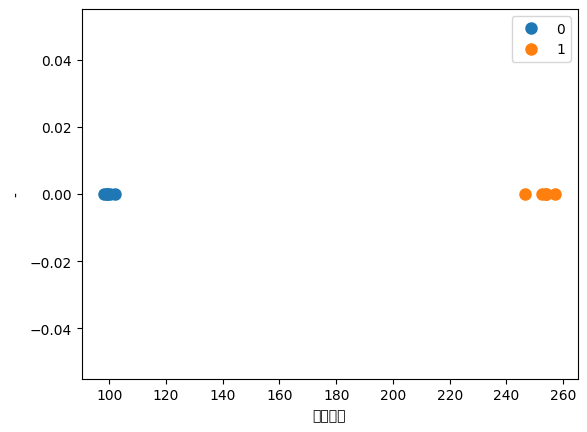

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 絶対値を取って分析ができる状態に持ってく
fft_len = int(len(ffted_privacy_wave[0,:])/2) - 1

# 振幅の平均値を算出(1次元に平均値を格納、2次元は0埋めしておく)
ffted_privacy_wave_abs = np.abs(ffted_privacy_wave[:,:fft_len])
ffted_privacy_wave_mean = np.zeros((2,DATA_COUNTS))
ffted_privacy_wave_mean[0,:] = np.array([np.mean(ffted_privacy_wave_abs[i,:]) for i in range(DATA_COUNTS)])

# k-means法でクラスタリング
cls_privacy = KMeans(n_clusters=2).fit_predict(ffted_privacy_wave_mean.T)

# グラフ表示用に成形
cls_privacy_pca1 = ffted_privacy_wave_mean[0:2,:].T #
df_privacy_pca = pd.DataFrame(cls_privacy_pca1, columns=["amplitude_mean","zero"])
df_privacy_class = pd.DataFrame(cls_privacy, columns=["class"])
df_privacy = pd.concat([df_privacy_pca, df_privacy_class], axis=1)

# グラフ表示
fig, ax = plt.subplots()
for name_p, group_p in df_privacy.groupby('class'):
    ax.plot(group_p.amplitude_mean, group_p.zero, marker='o', linestyle='', ms=8, label=name_p)
ax.legend()

plt.xlabel('振幅平均')
plt.ylabel('-')
plt.show()